# Pipeline for Machine Learning with Scikit-learn

Data preprocessing is an important step in machine learning. This step will determine how good an algorithm understand our dataset pattern, thus a good model is a model with good training data. But, this step can be a hassle since we need to prepare all of our data based on our training data shape. The process will be repetitive and become complex in real life. So we need a systematic preprocessing step that solve that problem which is pipeline method. 

In this project we will try using pipeline to prepare training and testing data. We will also compare it with preparing data using manual method, which is mutating the column one by one. At the end we will see the comparison and check if our pipeline method can solve things like our manual method.

The dataset that we used here was taken from [Kaggle](https://www.kaggle.com/datasets/arashnic/hr-analytics-job-change-of-data-scientists). The data is an observation of people who signup for training in a company and the target that we need to predict is which from those people who really looking for a new employment. This is a classification type of problem with variety of categorical and numerical predictor. The dataset is imbalance but we will not attend to that on this project. We will focus on how to use the pipeline to prepare the data instead.


## Import Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split 
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer

from sklearn.metrics import classification_report, f1_score
from sklearn import model_selection
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')

## Import Dataset

The dataset consists of 14 columns, 4 numerical and 10 categorical. One of the numerical is our `target` column, and another one is `enrollee_id` which shows unique number of each person so this can be counted as categorical data (which we will not use). On the contrary, one of the categorical data is `experience` that can be changed into numerical value. We will attend to this later.

**Features**

- **enrollee_id** : Unique ID for candidate
- **city**: City code
- **city_development_index** : Developement index of the city (scaled)
- **gender**: Gender of candidate
- **relevent_experience**: Relevant experience of candidate
- **enrolled_university**: Type of University course enrolled if any
- **education_level**: Education level of candidate
- **major_discipline** :Education major discipline of candidate
- **experience**: Candidate total experience in years
- **company_size**: No of employees in current employer's company
- **company_type** : Type of current employer
- **lastnewjob**: Difference in years between previous job and current job
- **training_hours**: training hours completed
- **target**: 0 – Not looking for job change, 1 – Looking for a job change

In [2]:
df = pd.read_csv("data_input/aug_train.csv")
df.head(3)

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0


## Exploratory Data
The first step is to check our data condition. Here we will see how many missing value and checking data types. We will also check the distribution of our numerical data to see if we have outliers in it. The dataset that we will use on EDA will be different than the data that we processed later, this is to make our test data pure and as similar as possible with unseen data that we will predict later.

#### Check missing values

In [3]:
df_eda = df.copy()

# count total missing value 
notna_count = df_eda.notnull().sum().reset_index()
isna_count = df_eda.isnull().sum().reset_index()
isna_percentage = (df_eda.isnull().sum()/len(df_eda)*100).reset_index()

# merge and sort missing value
missing = notna_count.merge(isna_count, on='index', how='inner')
missing = missing.merge(isna_percentage, on='index', how='inner')
missing.columns = ['index', 'notna', 'isna', 'isna(%)']
missing.sort_values(by='isna', ascending=False).head(9)

,index,notna,isna,isna(%)
10,company_type,13018,6140,32.049274
9,company_size,13220,5938,30.994885
3,gender,14650,4508,23.530640
7,major_discipline,16345,2813,14.683161
6,education_level,18698,460,2.401086
11,last_new_job,18735,423,2.207955
5,enrolled_university,18772,386,2.014824
8,experience,19093,65,0.339284
0,enrollee_id,19158,0,0.000000


In [4]:
# imbalance target variable
df_eda.target.value_counts(normalize=True)

0.0    0.750652
1.0    0.249348
Name: target, dtype: float64

As we can see, our data has 8 variable with missing values and the big three is company_type, company_size, and gender. The imbalance target data has a value ratio of 75:25.
Now we will check our data types and change some column which can be a category types.

In [5]:
# check data types
df_eda.dtypes

enrollee_id                 int64
city                       object
city_development_index    float64
gender                     object
relevent_experience        object
enrolled_university        object
education_level            object
major_discipline           object
experience                 object
company_size               object
company_type               object
last_new_job               object
training_hours              int64
target                    float64
dtype: object

We can change some of the variable above to be categorical types. The columns that can be categorical are:
- education_level
- company_size
- last_new_job
- city
- gender
- enrolled_university
- major_discipline
- company_type

While column experience will be changed into numerical for the exploratory step to see the distribution of observation there. We can use this column as either numerical or categorical in our model.

In [6]:
def experience_to_num(var):
    if var == '>20':
        return 21
    elif var == '<1':
        return 0.5
    else:
        return float(var)

df_eda['experience'] = df_eda['experience'].apply(experience_to_num)
df_eda['experience'] = df_eda['experience'].fillna(0)
df_eda.experience.dtypes

dtype('float64')

In [7]:
num_col = [col for col in df_eda.columns if df_eda[col].dtype != 'O']
num_col.remove('target')
num_col.remove('enrollee_id')
num_col

['city_development_index', 'experience', 'training_hours']

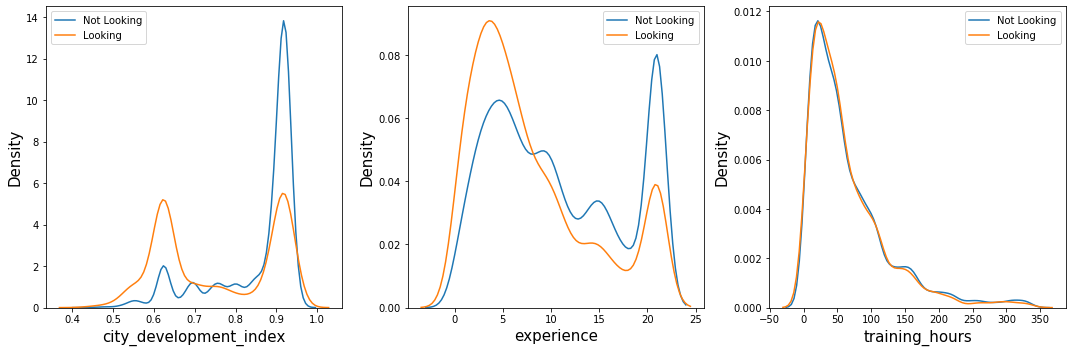

In [8]:
# check our numerical value distribution
rows = 1
cols = 3
plt.figure(figsize=(cols * 5, rows * 5))

for i, source in enumerate(num_col):
    plt.subplot(rows, cols, i+1)
    sns.kdeplot(df_eda.loc[df_eda['target'] == 0, source], label = 'Not Looking')
    sns.kdeplot(df_eda.loc[df_eda['target'] == 1, source], label = 'Looking')
    
    plt.xlabel('%s' % source, fontsize=15); plt.ylabel('Density', fontsize=15)
    
plt.tight_layout(h_pad = 5)

From the density plot above we can see that people in high city_development_index rather not looking for a new job. This is probably because since the development of the city is good, the people there already have a good job and join the training only to get the knowledge.

On the second plot we see that people with experience lower than 10 years still searching for a new job, probably they search the one with good payment. While people with 20 years or more experience tends to stay on their old jobs.

The third plot for training hours doesn't show any pattern that can be used on our analysis.

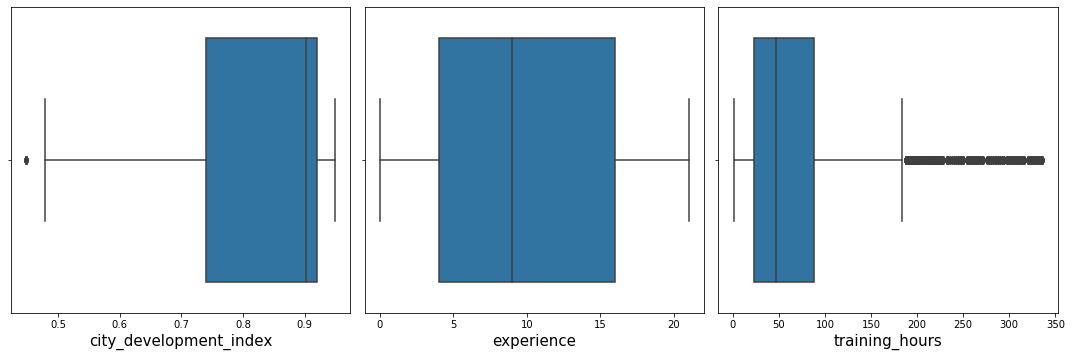

In [9]:
# check outliers with boxplot
rows = 2
cols = 3
plt.figure(figsize=(cols * 5, rows * 5))

for i, source in enumerate(num_col):
    plt.subplot(rows, cols, i+1)
    sns.boxplot(df_eda[source])
    
    plt.xlabel('%s' % source, fontsize=15)
    
plt.tight_layout(h_pad = 5)

There is some outliers in our data that shows people with high training hours and a person (or more) in a city with low city_development_index. While there is no outliers in experience column, and since the one with missing values is only experience we can fill the missing value with either mean or median.

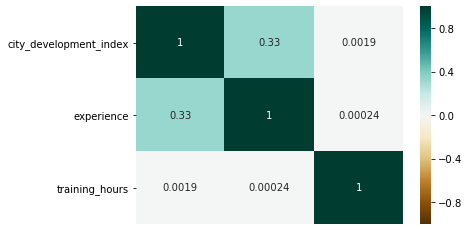

In [10]:
# check each predictor correlation 
# plt.figure(figsize = [10, 5])
sns.heatmap(df_eda[num_col].corr(), annot = True, vmin=-1, vmax=1, cmap='BrBG')
plt.tick_params(axis='x', which='both', bottom=False,
                top=False, labelbottom=False)

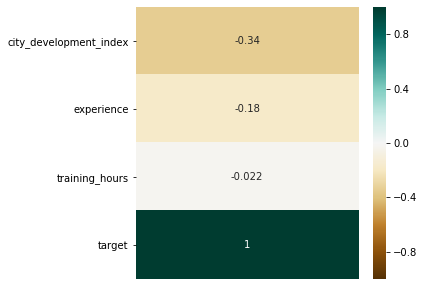

In [11]:
# Find correlations of predictor with target variable then sort them
num_col.append('target')
correlations = df_eda[num_col].corr()[['target']].sort_values('target')

# Display correlations
plt.figure(figsize = [5, 5])
sns.heatmap(correlations, annot = True, vmin=-1, vmax=1, cmap='BrBG')
plt.tick_params(axis='x', which='both', bottom=False,
                top=False, labelbottom=False)

The basic numerical columns has pretty low correlation between each other, with the highest correlation showed by city_development_index. It seems that we can use all of our predictor because there is no predictor with high correlation.

In [12]:
# Find correlations of predictor with target variable then sort them
correlations = df_eda.corr()['target'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(), sep='')
print('\nMost Negative Correlations:\n', correlations.head(), sep='')

Most Positive Correlations:
city_development_index   -0.341665
experience               -0.176461
training_hours           -0.021577
enrollee_id               0.049475
target                    1.000000
Name: target, dtype: float64

Most Negative Correlations:
city_development_index   -0.341665
experience               -0.176461
training_hours           -0.021577
enrollee_id               0.049475
target                    1.000000
Name: target, dtype: float64


## Separate Predictor and Target Variable
We will begin our data preparation with separating our predictor and target variable. We will also drop our `enrollee_id` variable because it is a unique value that will not have any significance to our model later.

In [13]:
X = df.drop(columns=['target', 'enrollee_id'])
y = df['target']

In [14]:
num_col = [col for col in X.columns if X[col].dtype != 'O']
cat_col = list(X.drop(columns=num_col).columns)

print('Numerical columns: ', num_col)
print('Categorical columns: ', cat_col)

Numerical columns:  ['city_development_index', 'training_hours']
Categorical columns:  ['city', 'gender', 'relevent_experience', 'enrolled_university', 'education_level', 'major_discipline', 'experience', 'company_size', 'company_type', 'last_new_job']


## Data Preparation & Training Models
We will discuss both manual and pipeline method. The data preprocessing step will be the same for both of them, just different approach. 

### Classifier without pipeline

This section will explain the process of data wrangling with manual method, so we have flexibility over the pipeline method. We can adjust things like if we want to apply a custom function, etc. to prepare our training data. While the method is flexible, it also comes with longer time to be done. We must apply the change one by one to our data train, data test, and new unseen data later when we use the model to predict.

In [15]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)
X1_train.shape, X1_test.shape, y1_train.shape, y1_test.shape

((15326, 12), (3832, 12), (15326,), (3832,))

In [16]:
X1_train.isna().sum().sort_values().tail(8)

experience               50
enrolled_university     305
last_new_job            334
education_level         369
major_discipline       2238
gender                 3579
company_size           4711
company_type           4903
dtype: int64

The first step is cleaning the data. As we can, see there are many missing values and all of them are on the categorical variables and we need to fill them. There are many ways and approach that we can use for filling this categorical values but for this part we will fill them with their mode. I make two function, first is for handling train and validation data and second for handling unseen data.

In [17]:
# Handling categorical columns

# main function
def cat_fillna(df_train, df_test, cat_columns):
    """
    df_train : train data
    df_test : test data
    """
    for var in cat_columns:
        df_train[var] = df_train[var].fillna(df_train[var].mode()[0])
        df_test[var] = df_test[var].fillna(df_train[var].mode()[0])

# use this one for preparing unseen data
def cat_fillna_unseen(df): 
    for var in cat_columns:
        df[var] = df[var].fillna(X1_train[var].mode()[0])        

## fill the missing value with mode
cat_fillna(X1_train, X1_test, cat_col)

The numerical variables has no missing value, so we can go straight to preparing the data. For numerical variables, we are going to use scaling since later on our model we will use KNN and SVM which rely on distance information. While for the categorical data we are going to make dummy variables.

In [18]:
# machine learning model training preparation
## apply scaling to numerical data
scaler = MinMaxScaler(feature_range=(0, 1))

X1_train[num_col] = scaler.fit_transform(X1_train[num_col])
X1_test[num_col] = scaler.transform(X1_test[num_col])

## make dummy variable (one hot encoding)
def onehot_encode_pd(df, cols):
    for col in cols:
        dummies = pd.get_dummies(df[col], prefix=col)
        df = pd.concat([df, dummies], axis=1).drop(columns=col)
    return df

X1_train = onehot_encode_pd(X1_train, cat_col)
## the code below also ensure the columns name and order sorted as the train data
X1_test = onehot_encode_pd(X1_test, cat_col).reindex(columns = X1_train.columns, fill_value=0)

Our data is ready, then we can move into making the models. Since we are trying to compare both pipeline and manual method, we are going to use four kind of models. All of the models have different approach on their algorithm so we can see the difference on both method diversely.

In [19]:
# compare some models
models=[]
models.append(('KNN', KNeighborsClassifier()))
models.append(('SVM', SVC(max_iter=500)))
models.append(('RF', RandomForestClassifier(random_state=42)))
models.append(('LR', LogisticRegression(solver='lbfgs', n_jobs=-1, random_state=42)))

# fitting/training model, then check the confusion matrix
print('F1-score')
for name, model in models:
    
    clf1 = model.fit(X1_train, y1_train)

    y1_pred = clf1.predict(X1_test)
    print(f'{name}: {round(f1_score(y1_test, y1_pred), 3)}')

F1-score
KNN: 0.434
SVM: 0.354
RF: 0.444
LR: 0.432


### Classifier with pipeline
The thing is, we will need to treat our unseen data (usually data that we need to predict, without label) the same as our training data to use them on our models. We need to take the code above and use it again when we get new data so it is kind of complicated to always do that. Luckily scikit-learn have a way to not only treat the new data as same as the old one, but also make a systematic process. This is what people said as pipeline.

While the pipeline is not as flexible as manual preprocessing data, it speed up our data preparation and make them tidier. 
We can also combine our categorical and numerical preprocessing in paralel. At this section, we will use some class from scikit-learn to make a data pipeline.

In [20]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)
X2_train.shape, X2_test.shape, y2_train.shape, y2_test.shape

((15326, 12), (3832, 12), (15326,), (3832,))

For the pipeline method, we are going to use classes from scikit-learn itself. The preprocessing step will be the same for each variables. Fill the missing value with mode for categorical data, then make their dummy variables with one hot encoding and scaling for our numerical variables. The syntax for making a pipeline is:
```
pipeline_1 = Pipeline([('name_1', transform_class_1()),
                      ('name_2', transform_class_2())]}
```
So we can chain our process step by step for each variables. From the parameter on Pipeline, two things that you need to define are name for each step (`name_1`, `name_2`) and the class to tranform or change our data value (`transform_class_1()`, `transform_class_2()`). The name can be whatever you want but the class should be scikit-learn transform classes. 
Complete documentation for pipeline can be seen [here](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html).

For our preprocessing, the step for each numerical and categorical variables can be written as the code below:

In [25]:
# pipeline for numerical feature
numerical_pipeline = Pipeline([
    ("scaler", MinMaxScaler())
])

# pipeline for categorical feature
categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown='ignore'))
])

After we define the pipeline for each type, we need to tell the pipeline what variables they need to change. This can be addressed by `ColumnTransformer()`. The syntax for this column transformer is:
```
ColumnTransformer([('name_3', pipeline_1, column_1),
                   ('name_4', pipeline_2, column_2)])
```
Let's suppose we make 2 pipeline, the first pipeline for numerical and the second for categorical. Things that we need to define on transformer parameter are name of the process, the pipeline to handle that process, and of course the list of columns that we are going to apply the transformers to. Full documentation for column transformer is written [here](http://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html).

Since the process on the example with our data is the same, we are going to make 2 step on our `ColumnTransformer()`, but we can define more than that, if for example we have different approach on some categorical data (like one using dummy variable, and other using LabelEncoder) we can separate them.

In [23]:
# concatenate the pipeline for both feature
preprocessor = ColumnTransformer([
    ("numeric", numerical_pipeline, num_col),
    ("categoric", categorical_pipeline, cat_col)
])

By this step, our data has not change at all. We will train our model with our pipeline and the process will be applying those transformation first then fitting the data into our model. The model we use are the same kind of model with our manual method.

In [24]:
models=[]
models.append(('KNN', KNeighborsClassifier()))
models.append(('SVM', SVC(max_iter=500)))
models.append(('RF', RandomForestClassifier(random_state=42)))
models.append(('LR', LogisticRegression(solver='lbfgs', n_jobs=-1, random_state=42)))

print('F1-score')
for name, model in models:
    pipeline = Pipeline([
        ('prep', preprocessor),
        ('algo', model)
    ])
    
    clf2 = pipeline.fit(X2_train, y2_train)

    y2_pred = clf2.predict(X2_test) 
    print(f'{name}: {round(f1_score(y2_test, y2_pred), 3)}')

F1-score
KNN: 0.434
SVM: 0.354
RF: 0.444
LR: 0.432


If we compare the F1-score from both method we get the value shown by the table below:

|| Without Pipeline | With Pipeline| 
| --- | --- | --- | 
| KNN | 0.434 | 0.434 | 
| SVM | 0.354 | 0.354 | 
| RF | 0.444 | 0.444 | 
| LR | 0.432 | 0.432 | 

**Conclusion**<br>
This means that Pipeline can help our preparation step to be easier and more systematic. With the same step of preprocessing we get the exact same value on our models. At this point, pipeline is the easier method to achieve the same result. But the problems come when we use complex preprocessing step, like making our own function to prepare our data, etc. We need to prepare more things to do that and learn more the use of FunctionTransformers, etc.

**Suggestion**<br>
Since our model has low f1-score, we can improve it next time by another preprocession step like separate the categorical variables into ordinal type and binary type, using SMOTE to handle imbalance data, handle the missing value using information on other columns, or do some feature engineering to our train dataset. That will not discussed here and you can check other people approach for this data on Kaggle.

#### Reference

https://machinelearningmastery.com/modeling-pipeline-optimization-with-scikit-learn/

https://machinelearningmastery.com/columntransformer-for-numerical-and-categorical-data/

https://www.kaggle.com/code/nkitgupta/who-will-leave-a-job#Model-